In [1]:
%run ../input/python-recipes/dhtml.py
dhtml('Lists of Image Files')

In [2]:
import numpy as np,pylab as pl
import os,zipfile,cv2

In [3]:
def get_files(dir_name,files_pre):
    files_list=sorted(os.listdir(dir_name))
    input_files=[f for f in files_list 
                 if (f[-4:]=='.jpg' and files_pre==f[:-7])]
    return input_files

dir_name='../input/object-detection/'
files_pre_list=['letters_01_'+'%02d'%l+'_00' 
                for l in range(2)]
input_files_list=[]
input_files_list+=[get_files(dir_name,files_pre_list[l])
                   for l in range(2)]
input_files_list

[['letters_01_00_00_01.jpg'],
 ['letters_01_01_00_01.jpg',
  'letters_01_01_00_02.jpg',
  'letters_01_01_00_03.jpg']]

In [4]:
dhtml('Lists of Objects')

In [5]:
def get_edges(file):
    img=cv2.imread(file)   
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges=cv2.Canny(gray_img,10,110) 
    cv2.waitKey(0)
    return img,gray_img,edges
img_list,gray_img_list,edges_list=[],[],[]
for l in range(2):
    curr_img_list,curr_gray_img_list,curr_edges_list=\
    [],[],[]
    for i in range(len(input_files_list[l])):        
        img,gray_img,edges=\
        get_edges(dir_name+input_files_list[l][i])
        curr_img_list+=[img]
        curr_gray_img_list+=[gray_img]
        curr_edges_list+=[edges]
    img_list+=[curr_img_list]
    gray_img_list+=[curr_gray_img_list]
    edges_list+=[curr_edges_list]  
[len(img_list[l]) for l in range(len(img_list))]

[1, 3]

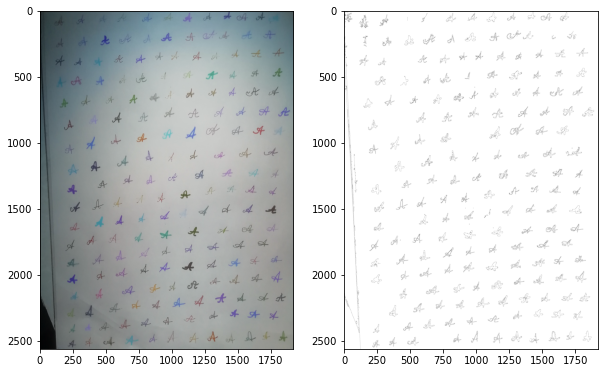

In [6]:
def display2images(img1,img2):
    fig=pl.figure(figsize=(10,10))
    ax=fig.add_subplot(1,2,1)
    pl.imshow(img1,cmap='Greys') 
    ax=fig.add_subplot(1,2,2)
    pl.imshow(img2,cmap='Greys')
    pl.show()
display2images(img_list[0][0],edges_list[0][0])

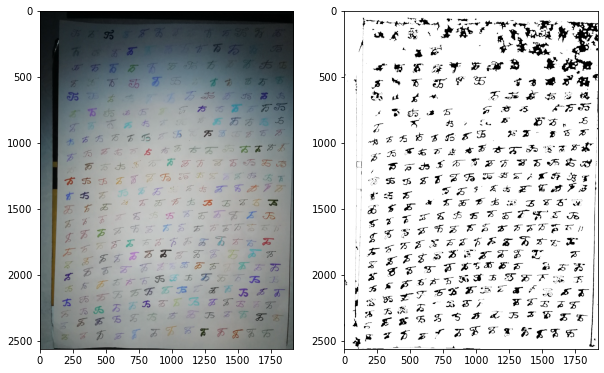

In [7]:
def get_closed(edges):
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(7,7)) 
    closed=cv2.morphologyEx(edges,cv2.MORPH_CLOSE,kernel) 
    cv2.waitKey(0)
    return closed
closed_list=[]
for l in range(2):
    curr_closed_list=[]
    for i in range(len(input_files_list[l])):
        closed=get_closed(edges_list[l][i])
        curr_closed_list+=[closed]
    closed_list+=[curr_closed_list]
display2images(img_list[1][0],closed_list[1][0])

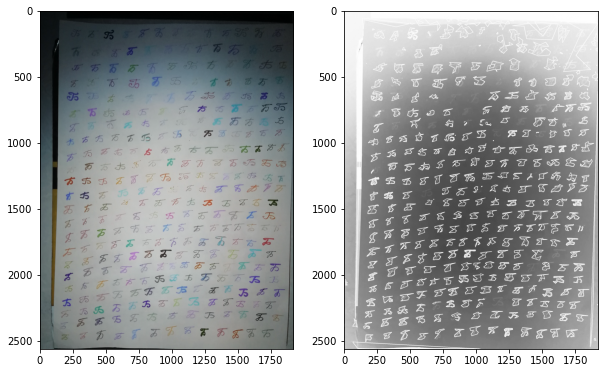

In [8]:
def get_contours(gray_img,closed):
    (contours, _)=cv2.findContours(
        closed.copy(),cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    for c in contours: 
        arc=cv2.arcLength(c,True) 
        approx_pdp=cv2.approxPolyDP(c,.02*arc,True) 
        contours_img=cv2.drawContours(
            gray_img,[approx_pdp],-1,(0,255,0),2) 
    cv2.waitKey(0) 
    return contours,contours_img
contours_list,contours_img_list=[],[]
for l in range(2):
    curr_contours_list,curr_contours_img_list=[],[]
    for i in range(len(input_files_list[l])):
        contours,contours_img=\
        get_contours(gray_img_list[l][i],
                     closed_list[l][i])
        curr_contours_list+=[contours]
        curr_contours_img_list+=[contours_img]
    contours_list+=[curr_contours_list]
    contours_img_list+=[curr_contours_img_list]
display2images(img_list[1][0],contours_img_list[1][0])

In [9]:
dhtml('New Data Files')

In [10]:
def create_zip(img_list,contours_list,files_pre_list):
    files_list_out=[]
    for l in range(2):
        file_name_zip=files_pre_list[l]+'.zip'
        idx=0
        for i in range(len(img_list[l])):
            contours=contours_list[l][i]
            img=img_list[l][i]
            for c in contours: 
                x,y,w,h=cv2.boundingRect(c)
                m=np.random.randint(5,21)
                if (w>30 and w<250 and h>30 and h<250):
                    y1=int(y*(1-.001*m))
                    y2=int((y+h)*(1+.001*m))
                    x1=int(x*(1-.001*m))
                    x2=int((x+w)*(1+.001*m))
                    new_img=img[y1:y2,x1:x2]
                    if min(new_img.shape[0],
                           new_img.shape[1])>30:
                        new_img=cv2.resize(new_img,(32,32))
                        start=files_pre_list[l].find('0')
                        file_name=files_pre_list[l][start:]+\
                                  '_%03d'%idx+'.png'
                        cv2.imwrite(file_name,new_img)
                        if idx==0:
                            with zipfile.ZipFile(file_name_zip,'w') as f:
                                f.write(file_name)
                        else:
                            with zipfile.ZipFile(file_name_zip,'a') as f:
                                f.write(file_name)
                        os.remove(file_name)
                        idx+=1 
        with zipfile.ZipFile(file_name_zip,'r') as f:
            curr_file_list_out=(f.namelist())
            f.close()
            files_list_out+=[curr_file_list_out]
    return files_list_out
files_list_out=create_zip(
    img_list,contours_list,files_pre_list)
[len(files_list_out[l]) for l in range(2)]

[173, 776]

In [11]:
dhtml('The Result Checking')

In [12]:
dir_out='../working/letters/'

def extract_images(dir_out=dir_out):
    if not os.path.exists(dir_out):
        os.makedirs(dir_out)
    zip_files_list=sorted(os.listdir('../working'))
    zip_files_list=[f for f in zip_files_list 
                    if f[-4:]=='.zip']
    print(zip_files_list)
    for i in range(len(zip_files_list)):
        with zipfile.ZipFile(zip_files_list[i],'r') as zf:
            zf.extractall(dir_out)
    files_list=sorted(os.listdir(dir_out))
    return zip_files_list,files_list
            
def display_images(n,files_list):
    fig=pl.figure(figsize=(10,n//1.5))
    randch=np.random.choice(
        len(files_list),size=n,replace=False)
    for i,idx in enumerate(randch):
        ax=fig.add_subplot(
            n//4,4,i+1,xticks=[],yticks=[])
        img=cv2.imread(dir_out+files_list[idx])
        ax.imshow(img)
        ax.set_title(files_list[idx]+'\n'+\
                     str(img.mean()),
                     fontsize=8)
    pl.show()                    

['letters_01_00_00.zip', 'letters_01_01_00.zip']
the number of extracted files: 949


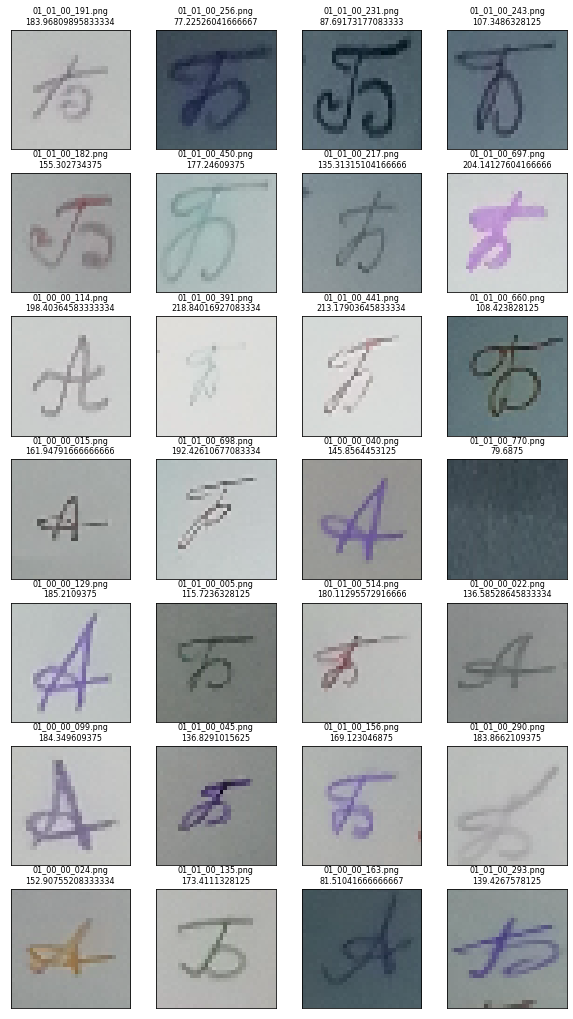

In [13]:
zip_files_list,files_list=extract_images()
print('the number of extracted files:',
      len(files_list))
display_images(28,files_list)

In [14]:
def check_image(img):
    output=True
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges=cv2.Canny(gray_img,10,150)        
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(7,7)) 
    closed=cv2.morphologyEx(edges,cv2.MORPH_CLOSE,kernel)
    (contours, _)=cv2.findContours(
        closed.copy(),cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE) 
    cv2.waitKey(0)
    cond1=(min(img.shape[0],img.shape[1])<30)
    cond2=(len(contours)!=1)
    cond3=(img.mean()<45 or img.mean()>250)
    if (cond1 or cond2 or cond3):
        output=False
    return output

def failed_images(dir_our=dir_out,
                  files_list=files_list):
    failed_list=[]
    for i in range(len(files_list)):
        img=cv2.imread(dir_out+files_list[i])
        if not check_image(img):
            failed_list+=[files_list[i]]
    return failed_list

the number of failed files: 115


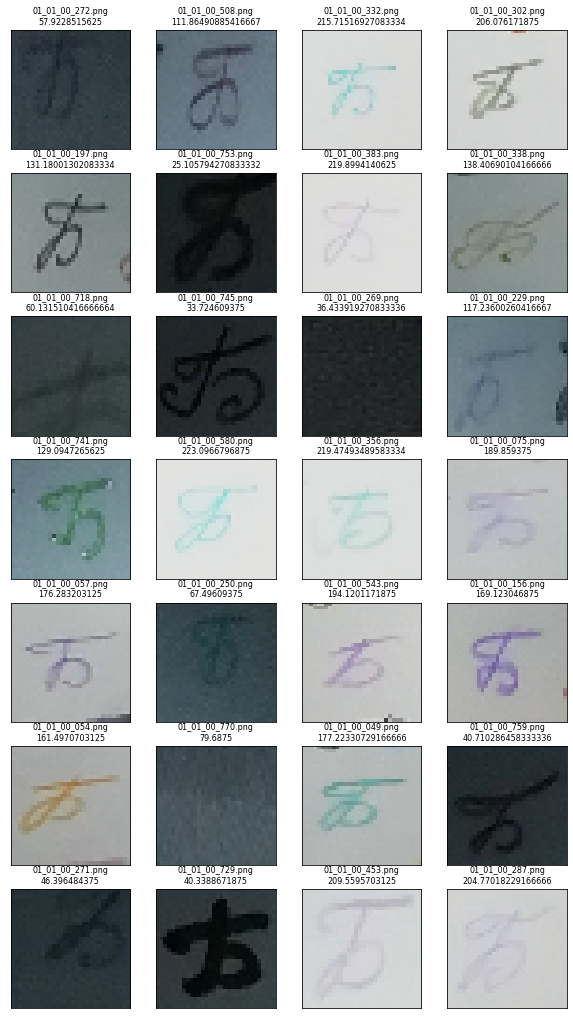

In [15]:
failed_list=failed_images(dir_our=dir_out,
                          files_list=files_list)
print('the number of failed files:',
      len(failed_list))
display_images(28,failed_list)

In [16]:
dhtml('Delete Working Materials')

In [17]:
for i in range(len(files_list)):
    os.remove(dir_out+files_list[i])
os.rmdir(dir_out)
for i in range(len(zip_files_list)):
    os.remove('../working/'+zip_files_list[i])
os.listdir('../working')

['__notebook__.ipynb']

In [18]:
dhtml('The Python Recipe')

In [19]:
%%writefile many_objects2images.py
import numpy as np,pylab as pl
import os,zipfile,cv2

def get_files(dir_name,files_pre):
    files_list=sorted(os.listdir(dir_name))
    input_files=[f for f in files_list 
                 if (f[-4:]=='.jpg' and files_pre==f[:-7])]
    return input_files

def get_edges(file):
    img=cv2.imread(file)   
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges=cv2.Canny(gray_img,10,110) 
    cv2.waitKey(0)
    return img,gray_img,edges

def get_closed(edges):
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(7,7)) 
    closed=cv2.morphologyEx(edges,cv2.MORPH_CLOSE,kernel) 
    cv2.waitKey(0)
    return closed

def get_contours(gray_img,closed):
    (contours, _)=cv2.findContours(
        closed.copy(),cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    for c in contours: 
        arc=cv2.arcLength(c,True) 
        approx_pdp=cv2.approxPolyDP(c,.02*arc,True) 
        contours_img=cv2.drawContours(
            gray_img,[approx_pdp],-1,(0,255,0),2) 
    cv2.waitKey(0) 
    return contours,contours_img

def check_image(img):
    output=True
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges=cv2.Canny(gray_img,10,150)        
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(7,7)) 
    closed=cv2.morphologyEx(edges,cv2.MORPH_CLOSE,kernel)
    (contours, _)=cv2.findContours(
        closed.copy(),cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE) 
    cv2.waitKey(0)
    cond1=(min(img.shape[0],img.shape[1])<30)
    cond2=(len(contours)!=1)
    cond3=(img.mean()<45 or img.mean()>250)
    if (cond1 or cond2 or cond3):
        output=False
    return output

def create_zip(img_list,contours_list,files_pre_list):
    files_list_out=[]
    N=len(files_pre_list)
    for l in range(N):
        start=files_pre_list[l].find('0')
        file_name_zip=files_pre_list[l][start:]+'.zip'
        idx=0
        for i in range(len(img_list[l])):
            contours=contours_list[l][i]
            img=img_list[l][i]
            for c in contours: 
                x,y,w,h=cv2.boundingRect(c)
                m=np.random.randint(5,21)
                if (w>30 and w<250 and h>30 and h<250):
                    y1=int(y*(1-.001*m))
                    y2=int((y+h)*(1+.001*m))
                    x1=int(x*(1-.001*m))
                    x2=int((x+w)*(1+.001*m))
                    new_img=img[y1:y2,x1:x2]
                    if check_image(new_img):
                        new_img=cv2.resize(new_img,(32,32))
                        file_name=files_pre_list[l][start:]+\
                                  '_%03d'%idx+'.png'
                        cv2.imwrite(file_name,new_img)
                        if idx==0:
                            with zipfile.ZipFile(file_name_zip,'w') as f:
                                f.write(file_name)
                        else:
                            with zipfile.ZipFile(file_name_zip,'a') as f:
                                f.write(file_name)
                        os.remove(file_name)
                        idx+=1 
        with zipfile.ZipFile(file_name_zip,'r') as f:
            curr_file_list_out=(f.namelist())
            f.close()
            files_list_out+=[curr_file_list_out]
    return files_list_out

dir_name='../input/object-detection/'
files_pre_list=['letters_01_'+'%02d'%l+'_00' 
                for l in range(2)]

def many_objects2images(dir_name=dir_name,
                        files_pre_list=files_pre_list):
    N=len(files_pre_list)
    input_files_list=[]
    input_files_list+=\
    [get_files(dir_name,files_pre_list[l])
     for l in range(N)]
    img_list,gray_img_list,edges_list=[],[],[]
    for l in range(N):
        curr_img_list=[]
        curr_gray_img_list=[]
        curr_edges_list=[]
        for i in range(len(input_files_list[l])):        
            img,gray_img,edges=\
            get_edges(dir_name+input_files_list[l][i])
            curr_img_list+=[img]
            curr_gray_img_list+=[gray_img]
            curr_edges_list+=[edges]
        img_list+=[curr_img_list]
        gray_img_list+=[curr_gray_img_list]
        edges_list+=[curr_edges_list]
    closed_list=[]
    for l in range(N):
        curr_closed_list=[]
        for i in range(len(input_files_list[l])):
            closed=get_closed(edges_list[l][i])
            curr_closed_list+=[closed]
        closed_list+=[curr_closed_list] 
    contours_list,contours_img_list=[],[]
    for l in range(N):
        curr_contours_list,curr_contours_img_list=[],[]
        for i in range(len(input_files_list[l])):
            contours,contours_img=\
            get_contours(gray_img_list[l][i],
                         closed_list[l][i])
            curr_contours_list+=[contours]
            curr_contours_img_list+=[contours_img]
        contours_list+=[curr_contours_list]
        contours_img_list+=[curr_contours_img_list]
    files_list_out=create_zip(
        img_list,contours_list,files_pre_list)
    print('Numbers of Images in Zip Files:\n',
          [len(files_list_out[l]) 
           for l in range(N)])

Writing many_objects2images.py


In [20]:
%run many_objects2images.py
many_objects2images()

Numbers of Images in Zip Files:
 [165, 618]


<Figure size 432x288 with 0 Axes>